In [1]:
n_fold= 1
total_fold= '5'
use_enchanced_dataset= False
model_name= "Try"

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import pickle

# Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from callback import MultipleClassAUROC

import util
from livelossplot import PlotLossesKeras

2022-12-01 13:28:53.604145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 13:28:53.809691: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-01 13:28:54.461928: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/cries/.conda/envs/Nabil_env/lib/
2022-12-01 13:28:54.462043: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plu

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')
print("Test built: {}".format(tf.test.is_built_with_cuda()))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
Test built: True


In [4]:
if use_enchanced_dataset == True:
    IMAGE_DIR = "/home/cries/Dataset/X-Ray/enchanced/"
else:
    IMAGE_DIR = "/home/cries/Dataset/X-Ray/original/images/"
    
train_df= pd.read_csv("/home/cries/Dataset/X-Ray/DataFrame/" + str(total_fold) + "Fold/" + "train_Fold" + str(n_fold) + ".csv").loc[:,'Image Index':]
test_df= pd.read_csv("/home/cries/Dataset/X-Ray/DataFrame/" + str(total_fold) + "Fold/" + "test_Fold" + str(n_fold) + ".csv").loc[:,'Image Index':]

labels = ['No Findings',            'Cardiomegaly', 
          'Emphysema',              'Effusion', 
          'Hernia',                 'Infiltration', 
          'Mass',                   'Nodule', 
          'Atelectasis',            'Pneumothorax',
          'Pleural_Thickening',     'Pneumonia', 
          'Fibrosis',               'Edema', 
          'Consolidation']
labels_col= labels
index_col= "Image Index"
print("Leakage between train and test: {}".format(util.check_for_leakage(train_df, test_df, 'Image Index')))

Leakage between train and test: False


In [5]:
# Setting
seed= 1
batch_size= 32
target_w= 320; target_h= 320; dim= (3,)
# target_w= 224; target_h= 224; dim= (3,)
image_size_target= (target_w,target_h)
image_shape= image_size_target + dim
class_mode= 'raw'   # raw, categorical 

use_aug= True
use_normalize= True
aug_norm = (use_aug, use_normalize)

============ getting train generator ===========
Found 4484 validated image filenames.

==== getting train and test/valid generators ====
Found 4484 validated image filenames.
Found 1122 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


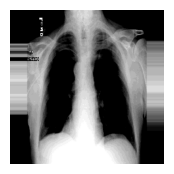

In [6]:
def prepare_generator(use_Aug, use_Normalize):
    # == Aug and Normalize Image 
    if use_Aug== True and use_Normalize== True:
        return ImageDataGenerator(
            brightness_range=[0.33,0.33],
            zoom_range=0.33,
            rescale= 1./255,        
            horizontal_flip= True,
            samplewise_center= True,
            samplewise_std_normalization= True
            )
    # == Aug Image
    if use_Aug== True and use_Normalize== False:
        return ImageDataGenerator(
            rescale= 1./255,        
            horizontal_flip= True,
            height_shift_range= 0.5,
            width_shift_range= 0.5,
            vertical_flip= True,
            rotation_range= 20,
            fill_mode= "nearest"
            )
    # == Normalize Image
    if use_Aug== False and use_Normalize== True:
        return ImageDataGenerator(
            rescale= 1./255,
            horizontal_flip= True,
            samplewise_center= True,
            samplewise_std_normalization= True
            )
    # == Without
    if use_Aug== False and use_Normalize== False:
        return ImageDataGenerator()

# ======================= IMAGE GENERATOR ===================

# === Image Train Generator
print("============ getting train generator ===========") 
image_train= prepare_generator(*aug_norm).flow_from_dataframe(
    dataframe= train_df,
    directory= IMAGE_DIR,
    x_col= index_col,
    y_col= labels,
    class_mode= class_mode,
    batch_size= batch_size,
    shuffle= True,
    target_size= image_size_target
)

# === Image Validation and Test Generator
print("")
print("==== getting train and test/valid generators ====")
raw_train_generator= prepare_generator(False, False).flow_from_dataframe(
                        dataframe= train_df,
                        directory= IMAGE_DIR,
                        x_col= index_col,
                        y_col= labels,
                        class_mode= class_mode,
                        batch_size= batch_size,
                        shuffle= True,
                        target_size= image_size_target
                    )
batch= raw_train_generator.next()
data_sample= batch[0]
imagegenerator= prepare_generator(*aug_norm)
imagegenerator.fit(data_sample)
image_val = imagegenerator.flow_from_dataframe(
                        dataframe= test_df,
                        directory= IMAGE_DIR,
                        x_col= index_col,
                        y_col= labels,
                        class_mode= class_mode,
                        batch_size= batch_size,
                        shuffle= False,
                        target_size= image_size_target
                    )

x, y = image_train.__getitem__(0)
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(x[0]);

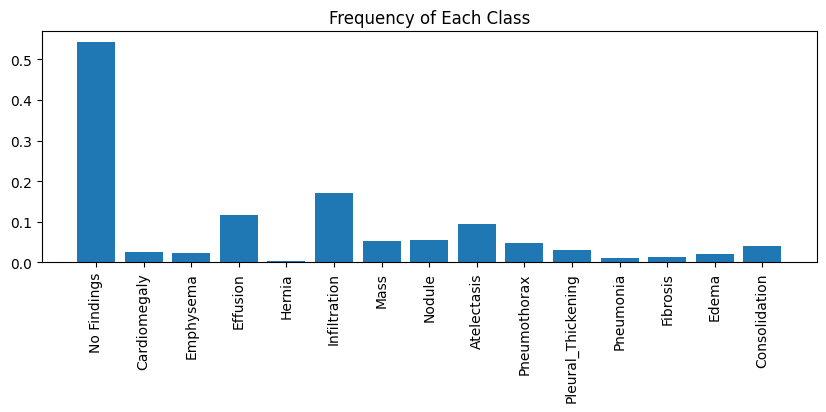

In [7]:
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(image_train.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [8]:
def compute_class_freqs(labels):
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies
    return positive_frequencies, negative_frequencies

freq_pos, freq_neg = compute_class_freqs(image_train.labels)
freq_pos

array([0.54192685, 0.02520071, 0.02363961, 0.11641392, 0.00223015,
       0.17105263, 0.05307761, 0.0544157 , 0.0941124 , 0.04772525,
       0.03077609, 0.01137377, 0.01449599, 0.02118644, 0.0396967 ])

/tmp/ipykernel_50142/3905682285.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


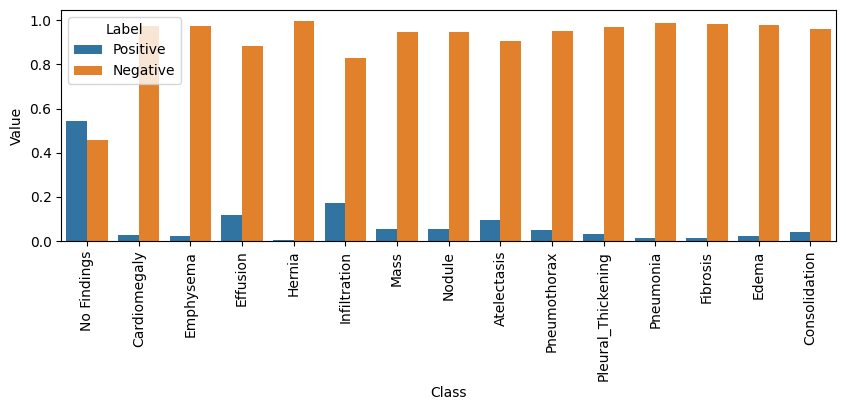

In [9]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

/tmp/ipykernel_50142/1531308047.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


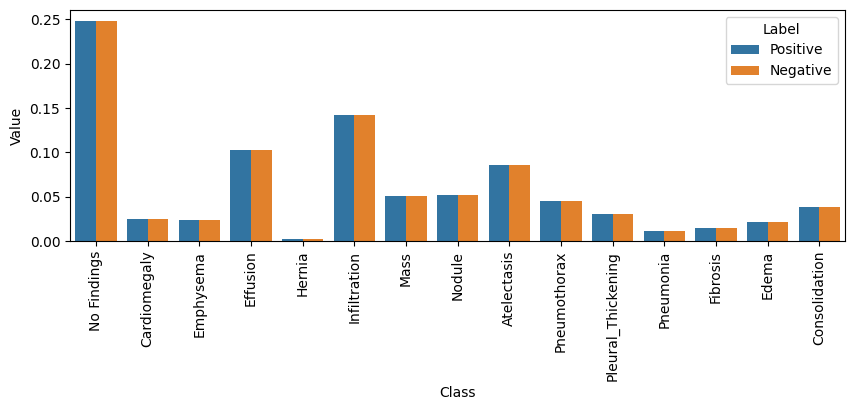

In [10]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [11]:
class_weights = util.generate_class_weights(image_train.labels, multi_class=False, one_hot_encoded=True)
class_weights

{0: 0.12301783264746227,
 1: 2.6454277286135692,
 2: 2.820125786163522,
 3: 0.572669220945083,
 4: 29.893333333333334,
 5: 0.38974358974358975,
 6: 1.2560224089635854,
 7: 1.2251366120218579,
 8: 0.7083728278041074,
 9: 1.3968847352024922,
 10: 2.166183574879227,
 11: 5.861437908496732,
 12: 4.598974358974359,
 13: 3.1466666666666665,
 14: 1.6794007490636704}

In [12]:
inputs= Input(shape=image_shape)
num_class = len(labels)
print("~> image shape={}\n~> num_class={}".format(image_shape,num_class))

~> image shape=(320, 320, 3)
~> num_class=15


In [13]:
pretrained = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_tensor=inputs)
# pretrained.trainable = False

mdl = GlobalAveragePooling2D()(pretrained.output)
head = BatchNormalization()(mdl)
# head = Dense(128, activation='LeakyReLU')(head)
head = Dense(num_class, activation='sigmoid')(head)
model = Model(inputs=inputs, outputs=head)

2022-12-01 13:29:03.133746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 13:29:03.691624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9570 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:04:00.0, compute capability: 7.5


In [14]:
output_dir = './output_weights/{}'.format(model_name)
weight_path = '{}_ckp_weights.h5'.format(model_name)

output_weights_path = os.path.join(output_dir, weight_path)

if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

auroc = MultipleClassAUROC(
            sequence=image_val,
            class_names=labels,
            weights_path=output_weights_path,
            workers=1,
        )
adaptive_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode="min", min_lr=1e-8)

In [15]:
epoch = 25

lr = 0.001
decay_rate = lr / epoch
momentum = 0.99
adam = tf.keras.optimizers.Adam(learning_rate=lr)
sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=False)
# From (Aug-Dense)
# adam = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=decay_rate, beta_2=decay_rate*decay_rate, epsilon=1e-07, amsgrad=False)
# sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, weight_decay=decay_rate, nesterov=False)

checkpoint = ModelCheckpoint(output_weights_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)
bce_ls = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0)

metric_auc = tf.keras.metrics.AUC(multi_label=True)
model.compile(loss=bce_ls, optimizer=adam, metrics=[metric_auc])

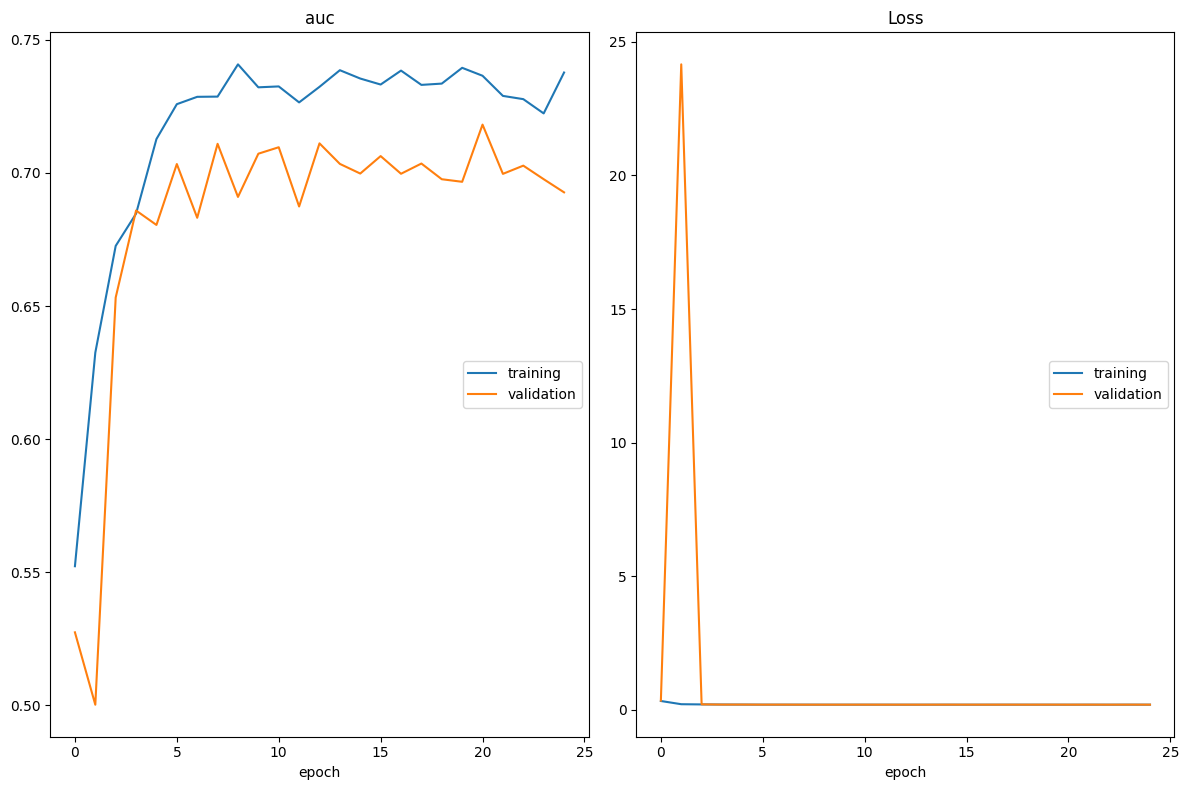

auc
	training         	 (min:    0.552, max:    0.741, cur:    0.738)
	validation       	 (min:    0.500, max:    0.718, cur:    0.693)
Loss
	training         	 (min:    0.190, max:    0.329, cur:    0.191)
	validation       	 (min:    0.192, max:   24.160, cur:    0.192)

*********************************
current learning rate: 9.99999993922529e-09


/home/cries/Workshop/X-Ray/TransX-Ray/src/callback.py:58: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_hat = self.model.predict_generator(self.sequence, workers=self.workers)


*** epoch#25 dev auroc ***
1. No Findings: 0.7240760214419452
2. Cardiomegaly: 0.6099177330895795
3. Emphysema: 0.691708836123005
4. Effusion: 0.8238114754098361
5. Hernia: 0.7107536490914508
6. Infiltration: 0.6682537960954447
7. Mass: 0.6785194763213189
8. Nodule: 0.6228167967298402
9. Atelectasis: 0.7395618209571697
10. Pneumothorax: 0.7154764846388271
11. Pleural_Thickening: 0.7288308409399884
12. Pneumonia: 0.6890598150724162
13. Fibrosis: 0.6895548026912249
14. Edema: 0.8753412192902639
15. Consolidation: 0.7521143699565487
*********************************
mean auroc: 0.7146531425232572
141/141 [==============================] - 228s 2s/step - loss: 0.1912 - auc: 0.7377 - val_loss: 0.1923 - val_auc: 0.6927 - lr: 1.0000e-08


In [16]:
start = time.time() 
history = model.fit(image_train, epochs=epoch, validation_data=image_val, callbacks=[checkpoint,PlotLossesKeras(), auroc, adaptive_lr],verbose=1)
end_train = time.time() - start

In [17]:
save_model_path = os.path.join(output_dir, 'model_{}'.format(model_name))
model.save(save_model_path)

INFO:tensorflow:Assets written to: ./output_weights/Try/model_Try/assets


INFO:tensorflow:Assets written to: ./output_weights/Try/model_Try/assets


In [18]:
final_weight_model_path = os.path.join(output_dir, '{}_weights.h5'.format(model_name))
model.save_weights(final_weight_model_path)
file_stats = os.stat(final_weight_model_path)
model_size = round(file_stats.st_size / (1024 * 1024), 2)
model_parameter = model.count_params()

In [19]:
with open('trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

/tmp/ipykernel_50142/2599839547.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model_fusion.predict_generator(image_val)


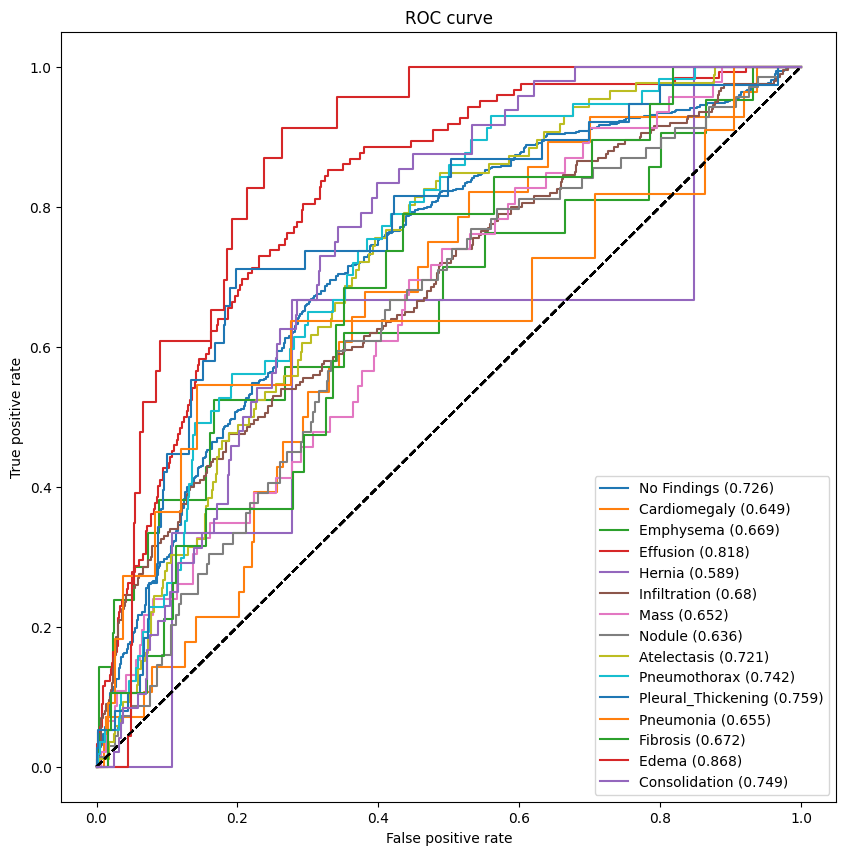

In [20]:
model_fusion = keras.models.load_model(save_model_path)
predicted_vals = model_fusion.predict_generator(image_val)
auc_rocs = util.get_roc_curve(labels, predicted_vals, image_val)

In [21]:
mean_auroc = np.mean(auc_rocs)
print("Mean AUC: {}".format(mean_auroc))

Mean AUC: 0.70578284307148


In [22]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()
print(device)

<CUDA device 0 'b'NVIDIA GeForce RTX 2080 Ti''>
